# Top-n Music Genre Classification Neural Network

This notebook attempts to build a Multi-layer Perceptron (MLP) artifical neural network model to predict the music genre(s) of an input audio sample.


My assessment is that creating a robust Convolutional Neural Network (CNN) for this task is too complicated for our alloted project timeframe, because to design the CNN architecture well, we likely need separate, thoughtfully designed convolutional branches and layers for each feature type that we decide to incorporate into the model in order to get the most accurate prediction. For each convolution computation, we would ultimately need to carefully consider the number of convolutional layers, the size of the kernels (filters), the stride, the padding, and the pooling layers, among other parameters. The optimal architecture depends on the specific characteristics of the input data and the problem being solved. For audio, this complexity is heightened because the temporal and frequency resolutions of the input features can vary widely.


## Setup

### 1. Install Dependencies

In [ ]:
# view the list of currently installed dependencies
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bi

In [4]:
!pip install --upgrade datasets lightgbm pytube xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


### 2. Define Imports

In [5]:
from concurrent.futures import ProcessPoolExecutor    # for multiprocessing during feature extraction
from datasets import load_dataset                     # to download the GTZAN dataset from HuggingFace
from glob import glob                                 # find files matching a pattern
from google.colab import files                        # to download the compressed model directory
import IPython.display as ipd                         # play an audio sample in the notebook
import joblib                                         # to save the fitted scaler and label encoder
from keras.callbacks import EarlyStopping             # to stop training when no loss improvement is detected
from keras.layers import Dense, Dropout               #
from keras.models import load_model, Sequential       #
from keras.optimizers import Adam                     #
from keras.utils import plot_model                    # to display a visual represntation of the model
import librosa                                        # audio processing and feature extraction
import librosa.display as lplt                        # display audio feature data
import matplotlib.pyplot as plt                       # plot and display audio feature data
import numpy as np                                    # linear algebra
import os                                             # traverse file tree
import pandas as pd                                   # data processing
from pytube import YouTube                           # to download audio files from YouTube
import scipy.stats as stats                           # for Q-Q plots
import seaborn as sns                                 # for histograms
import shutil                                         # copy directories
from sklearn.metrics import accuracy_score            #
from sklearn.model_selection import train_test_split  # split the dataset into train, validate and test datasets
from sklearn.preprocessing import LabelEncoder        # encode the labels
from sklearn.preprocessing import MinMaxScaler        # normalize the dataset
import soundfile as sf                                # to convert mp4 to wav
import tensorflow as tf                               # everything neural network related

# extra predictions using Gradient Boosting techniques
import lightgbm as lgb                                # light gradient boosting machine
import xgboost as xgb                                 # eXtreme gradient boosting

### 3. Check GPU Availability

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Avoid OOM errors by setting and thus limiting GPU memory consumption growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.set_memory_growth(gpu, True)

## Data Collection





### 1. Download the GTZAN Dataset

In [ ]:
# download the dataset
dataset = load_dataset("marsyas/gtzan", trust_remote_code=True)

# path to the downloaded gtzan dataset is in the /root/.cache/
dataset_cache_dir = '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244'

# set the destination directory in content/
destination_dir = '/content/raw/gtzan'

# remove the existing destination directory if it exists, then copy the dataset
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)
    print(f"Removed existing directory: {destination_dir}")

# attempt to copy the downloaded gtzan dataset to content/raw/gtzan
if os.path.exists(dataset_cache_dir):
    shutil.copytree(dataset_cache_dir, destination_dir)
    print("Dataset copied to:", destination_dir)
else:
    print("Dataset directory not found:", dataset_cache_dir)

Removed existing directory: /content/raw/gtzan
Dataset copied to: /content/raw/gtzan


### 2. Check the Number of Audio Files in the GTZAN Dataset

In [ ]:
# pattern to match .wav files in all GTZAN genre directories
pattern = '/content/raw/gtzan/genres/*/*.wav'

# find all audio files matching the pattern
audio_files = glob(pattern)

# print the number of audio files found
# the GTZAN dataset has 1000, 30-sec audio samples across 10 genres, 100 samples per genre
dataset_len = len(audio_files)
print("Number of expected .wav files in GTZAN dataset: 1000")
print("Number of actual .wav files in GTZAN dataset: ", dataset_len)

Number of expected .wav files in GTZAN dataset: 1000
Number of actual .wav files in GTZAN dataset:  1000


### 3. Play an Audio File for Testing Purposes

In [ ]:
ipd.Audio(audio_files[694])

## Data Loading, Feature Engineering, Data Processing, and Data Splitting

### 1. Extract Features and Save Raw Values into a CSV File

We will be extracting the statistical mean and variance for each audio feature extracted with Librosa (i.e. MFCC (the first 20), spectral bandwidth, spectral centroid, spectral contrast, spectral rolloff, mel spectrogram, chroma (stft), tonnetz, zero-crossing rate, root mean square, and tempo, amounting to 59 total audio features (i.e. the mfcc-1_mean and mfcc-1_variance are treated as two separate features).

In [ ]:
# # below is the extract_features function for the gtzan_3_sec_features.csv file
# # directory where the GTZAN dataset is stored
# dataset_dir = '/content/raw/gtzan/genres/'

# def extract_features(file_path):
#     # skip non-audio files and system files (i.e. files prefixed with '._')
#     if not file_path.endswith('.wav') or file_path.split(os.sep)[-1].startswith('._'):
#         return None

#     genre = file_path.split(os.sep)[-2]
#     filename = os.path.basename(file_path)
#     try:
#         y, sr = librosa.load(file_path)

#         # extract various features from the audio
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
#         spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
#         spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
#         spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#         spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
#         mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#         chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
#         tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
#         zcr = librosa.feature.zero_crossing_rate(y)
#         rms = librosa.feature.rms(y=y)
#         tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

#         # aggregate mean and variance of the features, adjusting mfcc aggregation
#         features = [filename]
#         for i in range(20):
#             features.append(np.mean(mfcc[i]))
#             features.append(np.var(mfcc[i]))
#         features += [np.mean(spectral_bandwidth), np.var(spectral_bandwidth)]
#         features += [np.mean(spectral_centroid), np.var(spectral_centroid)]
#         features += [np.mean(spectral_contrast), np.var(spectral_contrast)]
#         features += [np.mean(spectral_rolloff), np.var(spectral_rolloff)]
#         features += [np.mean(mel_spectrogram), np.var(mel_spectrogram)]
#         features += [np.mean(chroma_stft), np.var(chroma_stft)]
#         features += [np.mean(tonnetz), np.var(tonnetz)]
#         features += [np.mean(zcr), np.var(zcr)]
#         features += [np.mean(rms), np.var(rms)]
#         features += [tempo, genre]

#         return features

#     except Exception as e:
#         print(f"Error processing {filename}: {e}")
#         return None

# def process_files(dataset_dir):
#     file_paths = []
#     for root, dirs, files in os.walk(dataset_dir):
#         for file in files:
#             file_paths.append(os.path.join(root, file))

#     # define column names for the CSV file
#     columns = ['filename']
#     for i in range(20):
#         columns.append(f'mfcc-{i+1}_mean')
#         columns.append(f'mfcc-{i+1}_variance')
#     columns += [
#         'spectral-bandwidth_mean', 'spectral-bandwidth_variance',
#         'spectral-centroid_mean', 'spectral-centroid_variance',
#         'spectral-contrast_mean', 'spectral-contrast_variance',
#         'spectral-rolloff_mean', 'spectral-rolloff_variance',
#         'mel-spectrogram_mean', 'mel-spectrogram_variance',
#         'chroma-stft_mean', 'chroma-stft_variance',
#         'tonnetz_mean', 'tonnetz_variance',
#         'zcr_mean', 'zcr_variance',
#         'rms_mean', 'rms_variance',
#         'tempo',
#         'label'
#     ]

#     # process data files in parallel using multiprocessing
#     # extracting all of the above feature data for 1000 audio files
#     # could take a couple hours without this performance optimization
#     # (shoutout to operating systems for teaching me a thing or two haha)
#     data = []
#     with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
#         results = list(executor.map(extract_features, file_paths))

#     # filter out None results due to skipped or problematic files
#     data = [r for r in results if r is not None]

#     # create the processed directory if it does not exist
#     processed_dir = '/content/processed'
#     if not os.path.exists(processed_dir):
#         os.makedirs(processed_dir)

#     # create a DataFrame and save to CSV in the processed directory
#     df = pd.DataFrame(data, columns=columns)
#     csv_file_path = os.path.join(processed_dir, 'gtzan_30_sec_features.csv')
#     df.to_csv(csv_file_path, index=False)
#     print(f"Features extracted and saved to: {csv_file_path}")

# # extract features and create CSV file; it takes about 15-20 min in google colab
# process_files(dataset_dir)


# NOTE: below is the extract_features function for the gtzan_3_sec_features.csv file;
# the gtzan_3_sec_features.csv (not the gtzan_30_sec_features.csv) is used for the model training

# directory where the GTZAN dataset is stored
dataset_dir = '/content/raw/gtzan/genres/'

def extract_features(file_path):
    # skip non-audio files and system files (i.e. files prefixed with '._')
    if not file_path.endswith('.wav') or file_path.split(os.sep)[-1].startswith('._'):
        return None

    genre = file_path.split(os.sep)[-2]
    filename = os.path.basename(file_path)
    try:
        y, sr = librosa.load(file_path)
        segment_features = []  # list to hold features for each segment

        # process in 3-second segments
        for segment in range(10):  # Assuming 30s clips, so 10 segments of 3 seconds each
            start_sample = segment * 3 * sr  # 3 seconds * sample rate
            end_sample = start_sample + 3 * sr

            # check if the segment is shorter than expected and pad if necessary
            # this is crucial, because even though all audio files are 30 seconds,
            # the number of audio samples may not equate to exactly 30 seconds
            if len(y) < end_sample:
                y_segment = np.zeros((end_sample - start_sample,))  # Create a zero array
                y_segment[:len(y[start_sample:])] = y[start_sample:]  # Fill with available samples
                print(f"Padding applied to {filename} for segment {segment}")
            else:
                y_segment = y[start_sample:end_sample]

            # extract various features from the 3 second audio segment
            mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=20)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_segment, sr=sr)
            spectral_centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=y_segment, sr=sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)
            mel_spectrogram = librosa.feature.melspectrogram(y=y_segment, sr=sr)
            chroma_stft = librosa.feature.chroma_stft(y=y_segment, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=y_segment, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y_segment)
            rms = librosa.feature.rms(y=y_segment)
            tempo, _ = librosa.beat.beat_track(y=y_segment, sr=sr)

            # create a modified filename for this segment
            modified_filename = f"{filename[:-4]}.{segment}.wav"

            # aggregate mean and variance of the features, adjusting mfcc aggregation
            features = [modified_filename]
            for i in range(20):
                features.append(np.mean(mfcc[i]))
                features.append(np.var(mfcc[i]))
            features += [np.mean(spectral_bandwidth), np.var(spectral_bandwidth)]
            features += [np.mean(spectral_centroid), np.var(spectral_centroid)]
            features += [np.mean(spectral_contrast), np.var(spectral_contrast)]
            features += [np.mean(spectral_rolloff), np.var(spectral_rolloff)]
            features += [np.mean(mel_spectrogram), np.var(mel_spectrogram)]
            features += [np.mean(chroma_stft), np.var(chroma_stft)]
            features += [np.mean(tonnetz), np.var(tonnetz)]
            features += [np.mean(zcr), np.var(zcr)]
            features += [np.mean(rms), np.var(rms)]
            features += [tempo, genre]

            segment_features.append(features)

        return segment_features

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

def process_files(dataset_dir):
    file_paths = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            file_paths.append(os.path.join(root, file))

    # define column names for the CSV file
    columns = ['filename']
    for i in range(20):
        columns.append(f'mfcc-{i+1}_mean')
        columns.append(f'mfcc-{i+1}_variance')
    columns += [
        'spectral-bandwidth_mean', 'spectral-bandwidth_variance',
        'spectral-centroid_mean', 'spectral-centroid_variance',
        'spectral-contrast_mean', 'spectral-contrast_variance',
        'spectral-rolloff_mean', 'spectral-rolloff_variance',
        'mel-spectrogram_mean', 'mel-spectrogram_variance',
        'chroma-stft_mean', 'chroma-stft_variance',
        'tonnetz_mean', 'tonnetz_variance',
        'zcr_mean', 'zcr_variance',
        'rms_mean', 'rms_variance',
        'tempo',
        'label'
    ]

    # process data files in parallel using multiprocessing
    # extracting all of the above feature data for 10000 freakin audio files
    # could take several hours to a half day without this performance optimization
    # (shoutout to operating systems for teaching me a thing or two haha)
    data = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        # use executor.map to process files in parallel and flatten the list of lists
        results = list(executor.map(extract_features, file_paths))
        for result in results:
            if result is not None:
                data.extend(result)

    # filter out None results due to skipped or problematic files
    processed_dir = '/content/processed'
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    # create a DataFrame and save to CSV in the processed directory
    df = pd.DataFrame(data, columns=columns)
    csv_file_path = os.path.join(processed_dir, 'gtzan_3_sec_features.csv')
    df.to_csv(csv_file_path, index=False)
    print(f"Features extracted and saved to: {csv_file_path}")

# extract features and create CSV file
# it takes about 45 min (+/- 10 min) in google colab
process_files(dataset_dir)

<ipython-input-5-d1dc85b4cdba>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing jazz.00054.wav: 
Features extracted and saved to: /content/processed/gtzan_30_sec_features.csv


### 2. Display the CSV as a DataFrame

In [ ]:
# path to the CSV file
# csv_file_path = '/content/processed/gtzan_30_sec_features.csv'
csv_file_path = '/content/processed/gtzan_3_sec_features.csv'

# read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

# display the DataFrame info
print(df.info())

# display the first few rows of the DataFrame
print(df.head())

# display the data shape
print("Shape: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   filename                     9990 non-null   object 
 1   mfcc-1_mean                  9990 non-null   float64
 2   mfcc-1_variance              9990 non-null   float64
 3   mfcc-2_mean                  9990 non-null   float64
 4   mfcc-2_variance              9990 non-null   float64
 5   mfcc-3_mean                  9990 non-null   float64
 6   mfcc-3_variance              9990 non-null   float64
 7   mfcc-4_mean                  9990 non-null   float64
 8   mfcc-4_variance              9990 non-null   float64
 9   mfcc-5_mean                  9990 non-null   float64
 10  mfcc-5_variance              9990 non-null   float64
 11  mfcc-6_mean                  9990 non-null   float64
 12  mfcc-6_variance              9990 non-null   float64
 13  mfcc-7_mean       

### 3. Process the DataFrame

The 'filename' is not needed for analysis or the modeling process, so we will remove it from the Feature DataFrame. Also, we will handle any missing values.

In [ ]:
# check if 'filename' column exists in DataFrame and drop it if present
if 'filename' in df.columns:
    df = df.drop(labels='filename', axis=1)

# handle any rows containing missing values


# redisplay the DataFrame info
print(df.info())

# redisplay the first few rows of the DataFrame
print(df.head())

# redisplay the data shape
print("New Shape: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   mfcc-1_mean                  9990 non-null   float64
 1   mfcc-1_variance              9990 non-null   float64
 2   mfcc-2_mean                  9990 non-null   float64
 3   mfcc-2_variance              9990 non-null   float64
 4   mfcc-3_mean                  9990 non-null   float64
 5   mfcc-3_variance              9990 non-null   float64
 6   mfcc-4_mean                  9990 non-null   float64
 7   mfcc-4_variance              9990 non-null   float64
 8   mfcc-5_mean                  9990 non-null   float64
 9   mfcc-5_variance              9990 non-null   float64
 10  mfcc-6_mean                  9990 non-null   float64
 11  mfcc-6_variance              9990 non-null   float64
 12  mfcc-7_mean                  9990 non-null   float64
 13  mfcc-7_variance   

### 4. Assess Distribution of Feature Data

To determine whether we should apply normalization or standard scaling to the feature data, we can plot histograms and Q-Q plots for each feature. This will provide a visual indication of whether the data follows a Gaussian (normal) distribution.

How to Interpret Q-Q Plots:
- Close Alignment with the Line: If the points closely follow the diagonal line, this suggests that the feature's distribution approximates a Gaussian distribution.
- Deviations from the Line: Significant deviations from the diagonal line, especially in the tails, indicate that the feature's distribution deviates from normality.

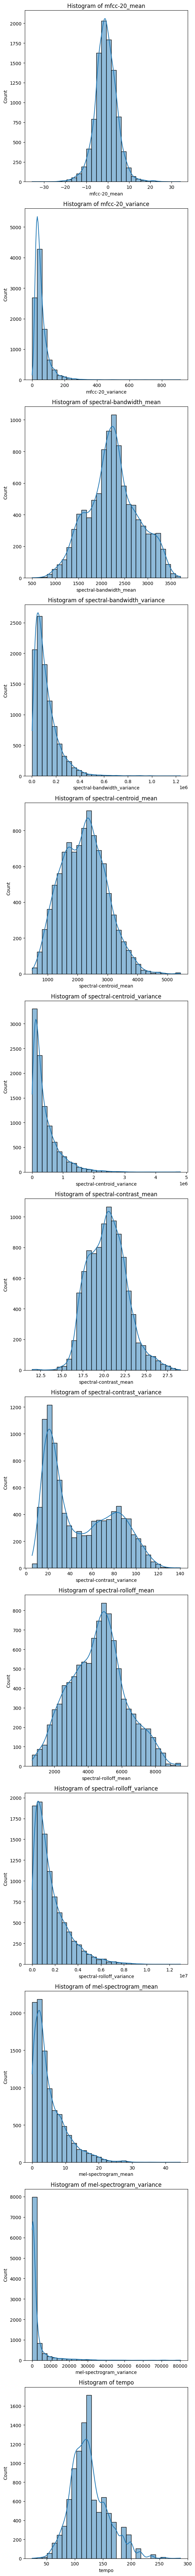

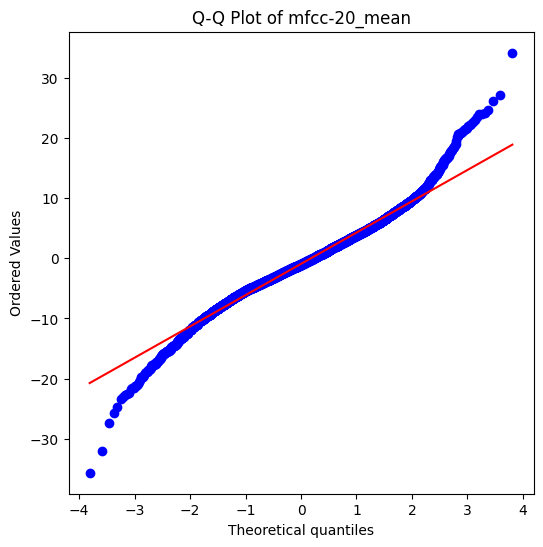

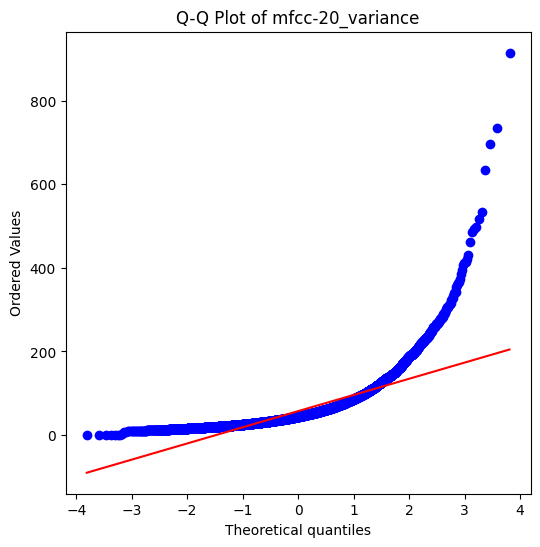

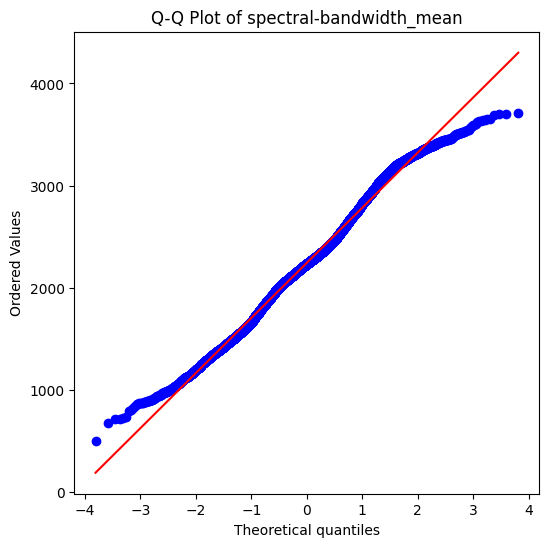

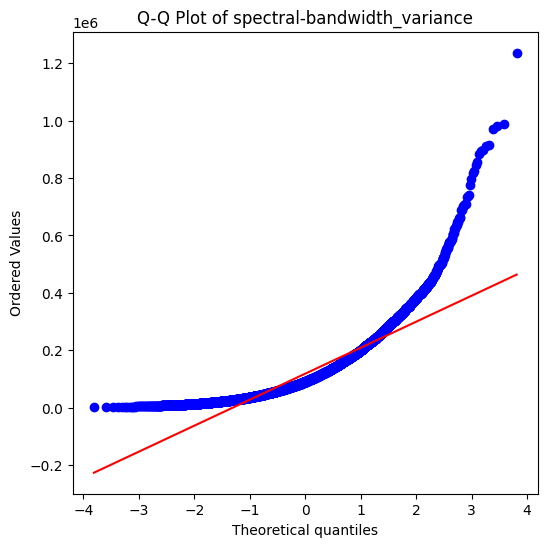

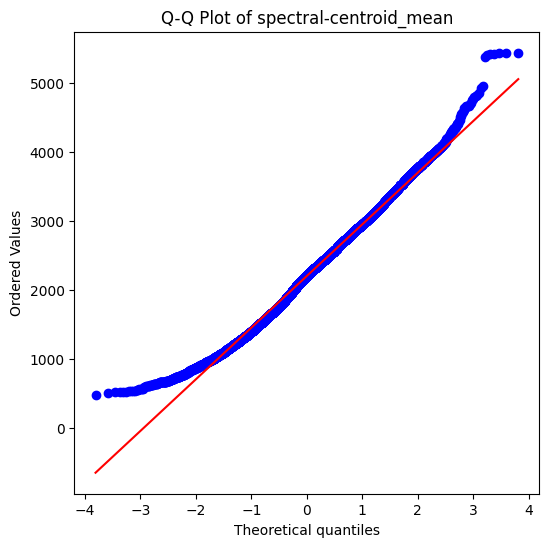

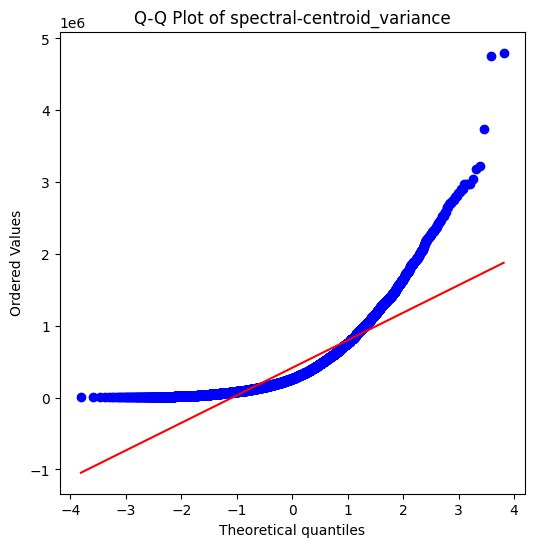

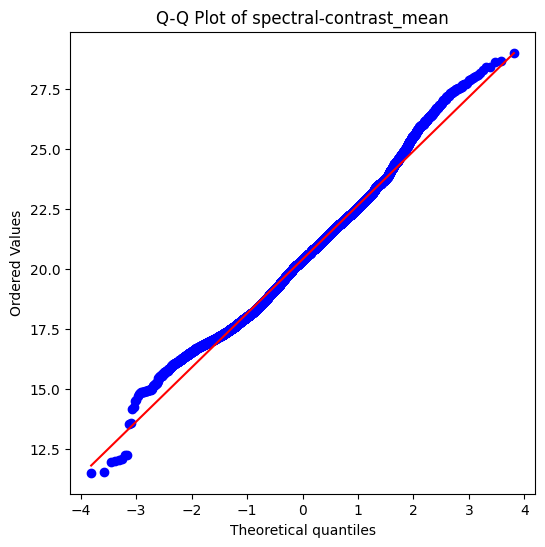

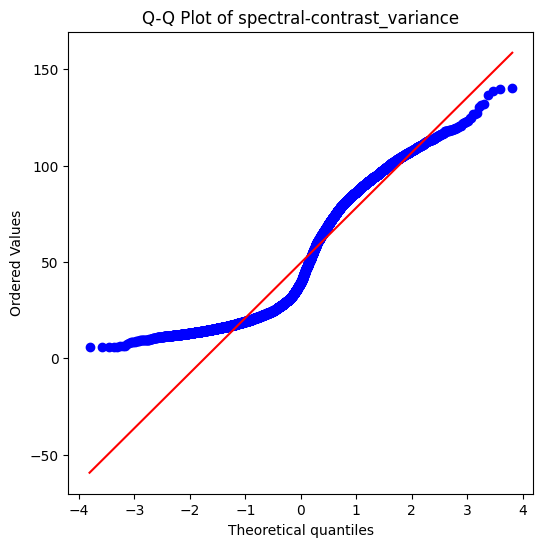

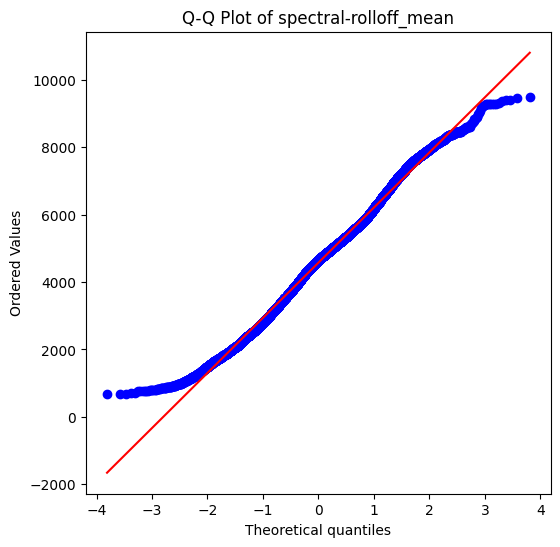

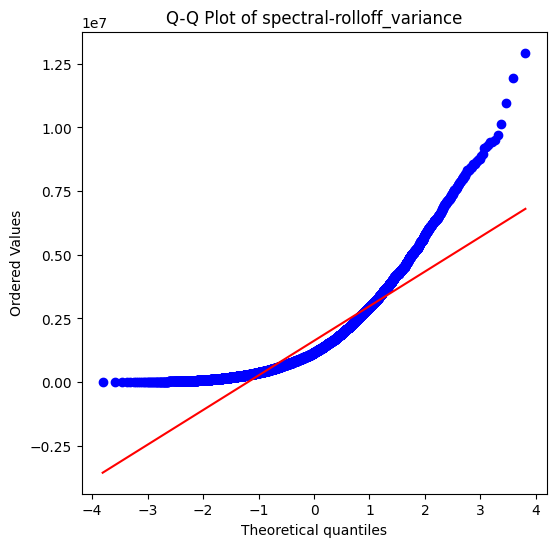

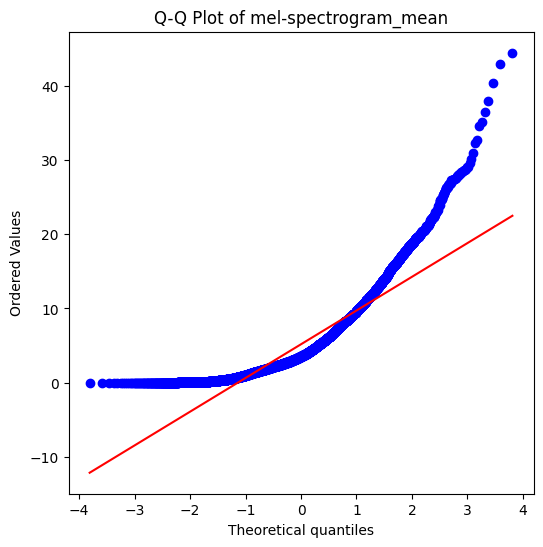

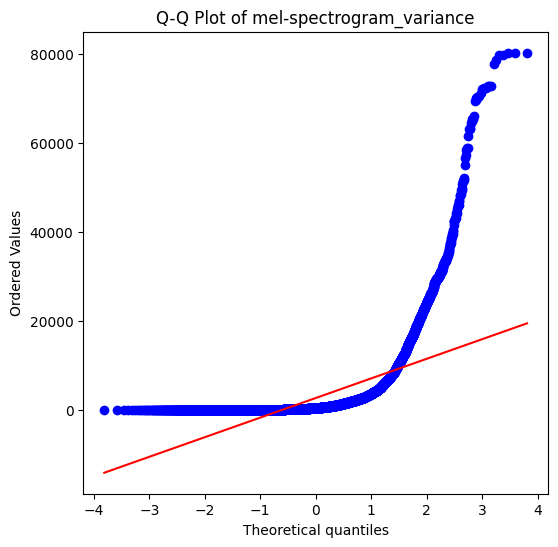

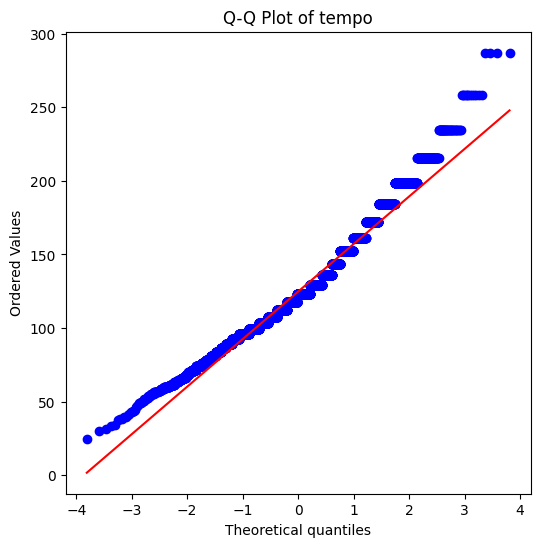

In [ ]:
features_to_plot = list(df.columns[38:50]) + ['tempo']
n_rows = len(features_to_plot)

# plot histograms for the above selection of features
plt.figure(figsize=(6, 6 * n_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, 1, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

# plot Q-Q plots for the same selection of features
for feature in features_to_plot:
    plt.figure(figsize=(6, 6))
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')
    plt.show()

### 5. Feature Normalization / Standard Scaling

Deciding on Preprocessing Based on Distribution Results (Above):

If the features do not appear to be normally distributed, using MinMaxScaler for normalization might be more appropriate. If the features are (or are close to) normally distributed, or if the chosen algorithms assume normality, using StandardScaler to standardize the features may be beneficial.

Considering many of the variance values of the selected features don't appear symmetric in distribution, I have decided to apply MinMaxScaler (instead of StandardScaler) for normalization to all the features.

In [ ]:
# separate features and labels; labels are in the last column
X = df.drop(columns=[df.columns[-1]])  # this removes the label column (because we aren't normalizing those)
y = df[df.columns[-1]]  # this selects the label column

# initialize the MinMaxScaler
scaler = MinMaxScaler()

# fit the scaler to the features and transform them to range [0, 1]
X_scaled = scaler.fit_transform(X)

# save the fitted scaler to disk for later use
joblib.dump(scaler, '/content/scaler.joblib')

# convert the scaled features back to a DataFrame (for ease of use)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# add the unscaled labels back into the DataFrame
X_scaled_df['label'] = y.values

# view the first few rows of the normalized DataFrame
print(X_scaled_df.head())

   mfcc-1_mean  mfcc-1_variance  mfcc-2_mean  mfcc-2_variance  mfcc-3_mean  \
0     0.824303         0.022330     0.272232         0.031172     0.483494   
1     0.829638         0.020593     0.325998         0.050807     0.472393   
2     0.824531         0.023611     0.323519         0.044259     0.540822   
3     0.831542         0.019265     0.287802         0.040716     0.490897   
4     0.842015         0.009760     0.281207         0.050721     0.484750   

   mfcc-3_variance  mfcc-4_mean  mfcc-4_variance  mfcc-5_mean  \
0         0.053544     0.440603         0.066389     0.647947   
1         0.078811     0.376956         0.117753     0.574031   
2         0.078311     0.331428         0.102157     0.585971   
3         0.062321     0.246908         0.079355     0.579124   
4         0.061610     0.226636         0.184846     0.481845   

   mfcc-5_variance  ...  chroma-stft_mean  chroma-stft_variance  tonnetz_mean  \
0         0.041807  ...          0.664340              0.56

### 6. Label Encoding

In [ ]:
# assuming the genre labels are in the last column, extract the labels
y = df[df.columns[-1]]

# initialize the LabelEncoder
label_encoder = LabelEncoder()

# fit the label encoder to the genre labels and transform them into numerical format
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)

# save the fitted LabelEncoder to disk for later use
joblib.dump(label_encoder, '/content/label_encoder.joblib')

# convert the encoded labels back to a DataFrame or Series (for ease of use)
y_encoded_series = pd.Series(y_encoded, name='Encoded Genre Labels')
print(y_encoded_series)

# see the mapping of genres to encoded values
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Genre to Encoded Value Mapping:", mapping)

# view the first few rows of the encoded labels
print(f"Encoded Series Head: \n{y_encoded_series.head()}")

[4 4 4 ... 9 9 9]
0       4
1       4
2       4
3       4
4       4
       ..
9985    9
9986    9
9987    9
9988    9
9989    9
Name: Encoded Genre Labels, Length: 9990, dtype: int64
Genre to Encoded Value Mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
Encoded Series Head: 
0    4
1    4
2    4
3    4
4    4
Name: Encoded Genre Labels, dtype: int64


### 7. Split the Data into Train, Validate, and Test Datasets

Data shuffling is handled by 'train_test_split' function when the datasets are divided (so we don't need to manually write a function to ensure data randomness).

In [ ]:
# since X_scaled and y_encoded are already prepared
X = X_scaled  # features are already scaled
y = y_encoded  # labels are already encoded

# first split: separate out the training dataset (70% of the original dataset)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# second split: divide the temporary dataset into validation and testing datasets (15% each of the original dataset)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# now we have:
# X_train, y_train - training set (70% of the original dataset)
# X_val, y_val - validation set (15% of the original dataset)
# X_test, y_test - testing set (15% of the original dataset)

# print the distribution of genres in the training, validation, and testing sets
print("Distribution in Training Set:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribution in Validation Set:")
print(pd.Series(y_val).value_counts(normalize=True))

print("\nDistribution in Testing Set:")
print(pd.Series(y_test).value_counts(normalize=True))

Distribution in Training Set:
6    0.100100
9    0.100100
0    0.100100
3    0.100100
2    0.100100
4    0.100100
7    0.100100
8    0.100100
1    0.100100
5    0.099099
dtype: float64

Distribution in Validation Set:
4    0.100134
3    0.100134
9    0.100134
7    0.100134
6    0.100134
8    0.100134
0    0.100134
2    0.100134
1    0.100134
5    0.098798
dtype: float64

Distribution in Testing Set:
2    0.100067
0    0.100067
1    0.100067
4    0.100067
6    0.100067
9    0.100067
3    0.100067
8    0.100067
7    0.100067
5    0.099400
dtype: float64


## Model Training and Testing

### 1. Train Multi-layer Perceptron Neural Network Model

In [ ]:
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

# define the model architecture
model = Sequential([
    # input layer
    Dense(512, activation='relu', input_shape=(num_features,)),
    Dropout(0.2),

    # hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.2),

    # hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.2),

    # hidden layer 3
    Dense(64, activation='relu'),
    Dropout(0.2),

    # # uncomment below and comment above to test a two hidden layer architecture
    # # input layer
    # Dense(256, activation='relu', input_shape=(num_features,)),
    # Dropout(0.2),

    # # hidden layer 1
    # Dense(128, activation='relu'),
    # Dropout(0.2),

    # # hidden layer 2
    # Dense(64, activation='relu'),
    # Dropout(0.2),

    # output layer
    Dense(num_classes, activation='softmax')
])

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

# model summary
model.summary()

# fit the model
# history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val))
# history = model.fit(X_train, y_train, epochs=750, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=750, batch_size=128, validation_data=(X_val, y_val))
# history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_val, y_val))
# history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30720     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

### 2. Evaluate the Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Extract the validation accuracy history
validation_accuracy = history.history['val_accuracy']

# Find the epoch at which the highest validation accuracy was achieved
best_epoch = validation_accuracy.index(max(validation_accuracy))

# Print the best validation accuracy
print(f"Best Validation Accuracy: {max(validation_accuracy)*100:.2f}% at epoch {best_epoch+1}")

47/47 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.9159
Test Loss: 0.4364
Test Accuracy: 91.59%
Best Validation Accuracy: 93.39% at epoch 410


### 3. Plot Model Loss and Accuracy

Overfitting is generally indicated when the training loss continues to decrease, but the validation loss starts to increase, signifying that the model is fitting the training data more closely but performing poorly on unseen data.

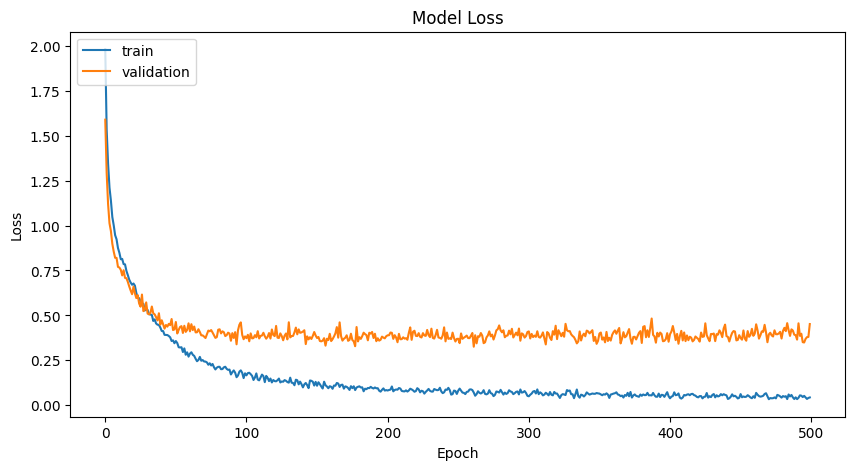

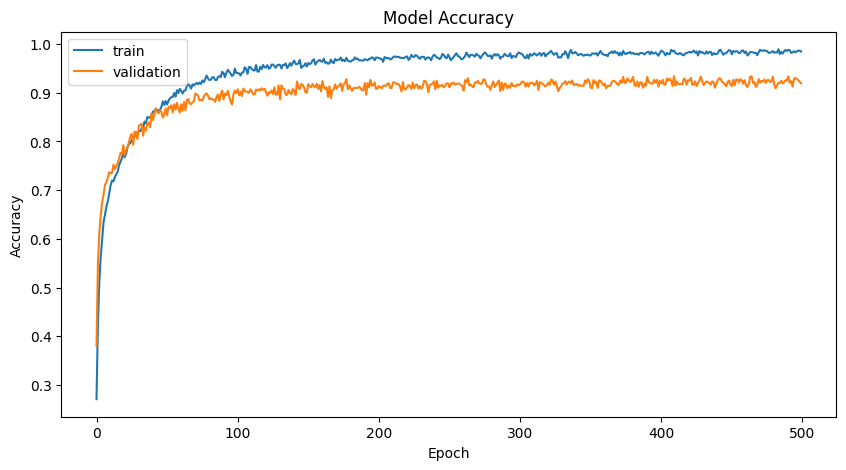

In [ ]:
# plot for model loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# plot for model accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### 4. Visualize the Model Architecture

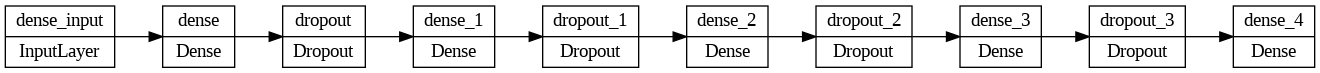

In [ ]:
# visualize the model
plot_model(model, to_file='top-n_mlp-nn-model-architecture.png', show_shapes=False, show_layer_names=True, rankdir='LR')

### 5. Save the Model

In [ ]:
# save the model
model.save('modelito')

# zip the model directory
!zip -r modelito.zip /content/modelito

# download the zipped model directory
files.download('modelito.zip')

  adding: content/modelito/ (stored 0%)
  adding: content/modelito/assets/ (stored 0%)
  adding: content/modelito/variables/ (stored 0%)
  adding: content/modelito/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/modelito/variables/variables.index (deflated 63%)
  adding: content/modelito/keras_metadata.pb (deflated 90%)
  adding: content/modelito/saved_model.pb (deflated 88%)
  adding: content/modelito/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 6. Save the Model to Google Cloud Storage Bucket

In [ ]:
# save the model to cloud storage bucket
BUCKET_NAME = ""
BUCKET_URI = f"gs://{BUCKET_NAME}"
BUCKET_DIRECTORY = f"gs://{BUCKET_NAME}/"

In [ ]:
model.save(BUCKET_DIRECTORY)

# Predict

### 1. Download a New Audio Sample from YouTube

In [6]:
# the URL of the YouTube video you want to download
# video_url = 'https://www.youtube.com/watch?v=oica5jG7FpU' # the thrill is gone by b.b. king
# video_url = 'https://www.youtube.com/watch?v=g3aIVzoEaI0&list=RDTZCfydWF48c&index=2'  # waltz of the flowers by tchaikovsky
# video_url = 'https://www.youtube.com/watch?v=1vrEljMfXYo' # take me home, country roads by john denver
# video_url = 'https://www.youtube.com/watch?v=fNFzfwLM72c' # stayin, alive by bee gees
# video_url = 'https://www.youtube.com/watch?v=_JZom_gVfuw' # juicy by notorious b.i.g.
# video_url = 'https://www.youtube.com/watch?v=vmDDOFXSgAs'  # take five by dave brubeck
# video_url = 'https://www.youtube.com/watch?v=E0ozmU9cJDg' # master of puppets by metallica
# video_url = 'https://www.youtube.com/watch?v=Zi_XLOBDo_Y' # billie jean by michael jackson
# video_url = 'https://www.youtube.com/watch?v=CoabDBD1N2Q' # three little birds by bob marley
# video_url = 'https://www.youtube.com/watch?v=pAgnJDJN4VA' # back in black by ac/dc
# video_url = 'https://www.youtube.com/watch?v=eaPzCHEQExs' # hypnotize by notorious b.i.g.
video_url = 'https://youtu.be/aXgSHL7efKg?si=xoN0lutMTJB247gd' # le freak by chic

# path where you want to save the audio file
output_path = '/content/audio-samples'

# filename without extension
# filename = 'the-thrill-is-gone_bb-king_blues'
# filename = 'waltz-of-the-flowers_tchaikovsky_classical'
# filename = 'take-me-home-country-roads_john-denver_country'
# filename = 'stayin-alive_bee-gees_disco'
# filename = 'juicy_notorious-big_hip-hop'
# filename = 'take-five_dave-brubeck_jazz'
# filename = 'master-of-puppets_metallica_metal'
# filename = 'billie-jean_michael-jackson_pop'
# filename = 'three-little-birds_bob-marley_reggae'
# filename = 'back-in-black_acdc_rock'
# filename = 'hypnotize_notorious-big_hiphop'
filename = 'le-freak_chic_disco'

# create a YouTube object with the URL
yt = YouTube(video_url)

# select the highest quality audio stream
audio_stream = yt.streams.get_audio_only()

# download the audio stream
downloaded_file = audio_stream.download(output_path=output_path, filename=filename + '.mp4')
print(downloaded_file)

# load the audio file with librosa, maininging the original sample rate (i.e. sr=None)
audio, sr = librosa.load(downloaded_file, sr=None)

# save the audio file in WAV format using soundfile
output_file = os.path.join(output_path, filename + '.wav')
sf.write(output_file, audio, sr)

# delete the original MP4 file
os.remove(downloaded_file)

print(f"Downloaded and converted {video_url} to {output_file}")

/content/audio-samples/le-freak_chic_disco.mp4


<ipython-input-6-36f62672c406>:43: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(downloaded_file, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Downloaded and converted https://youtu.be/aXgSHL7efKg?si=xoN0lutMTJB247gd to /content/audio-samples/le-freak_chic_disco.wav


### 2. Play the Audio Sample for Testing Purposes

In [ ]:
# pattern to match .wav files in all GTZAN genre directories
pattern = '/content/audio-samples/*.wav'

# find all audio samples matching the pattern
audio_samples = glob(pattern)
print(audio_samples)

# play an audio sample
ipd.Audio(audio_samples[0])

['/content/audio-samples/waltz-of-the-flowers_tchaikovsky_classical.wav']


### 3. Crop the Audio Sample

In [ ]:
# we already have code for this
def crop_audio_sample(input_path, output_path):
  """Crops the audio sample into 30 second segments."""
  # Load the audio file
  y, sr = librosa.load(input_path, sr=None)

  # Calculate the total duration in seconds
  total_duration = librosa.get_duration(y=y, sr=sr)

  # Calculate the start time for the middle 30 seconds crop
  if total_duration <= 30:
    start_sec = 0
    end_sec = total_duration
  else:
    middle = total_duration / 2
    start_sec = max(0, middle - 15)
    end_sec = start_sec + 30

  # Convert start time and end time to sample indices
  start_sample = int(start_sec * sr)
  end_sample = int(end_sec * sr)

  # Crop the audio
  cropped_audio = y[start_sample:end_sample]

  # Write the cropped audio to a new file
  sf.write(output_path, cropped_audio, sr)

# Usage

# input_path = '/content/audio-samples/stayin-alive_bee-gees_disco.wav'
# output_path = '/content/audio-samples/stayin-alive_bee-gees_disco_30_sec.wav'
# input_path = '/content/audio-samples/master-of-puppets_metallica_metal.wav'
# output_path = '/content/audio-samples/master-of-puppets_metallica_metal_30_sec.wav'
# input_path = '/content/audio-samples/three-little-birds_bob-marley_reggae.wav'
# output_path = '/content/audio-samples/three-little-birds_bob-marley_reggae_30_sec.wav'
# input_path = '/content/audio-samples/back-in-black_acdc_rock.wav'
# output_path = '/content/audio-samples/back-in-black_acdc_rock_30_sec.wav'
# input_path = '/content/audio-samples/take-five_dave-brubeck_jazz.wav'
# output_path = '/content/audio-samples/take-five_dave-brubeck_jazz_30_sec.wav'
# input_path = '/content/audio-samples/juicy_notorious-big_hip-hop.wav'
# output_path = '/content/audio-samples/juicy_notorious-big_hip-hop_30_sec.wav'
# input_path = '/content/audio-samples/hypnotize_notorious-big_hiphop.wav'
# output_path = '/content/audio-samples/hypnotize_notorious-big_hiphop_30_sec.wav'
input_path = '/content/audio-samples/le-freak_chic_disco.wav'
output_path = '/content/audio-samples/le-freak_chic_disco_30_sec.wav'
crop_audio_sample(input_path, output_path)

### 4. Extract Audio Features and Prepare Dataframe

In [ ]:
# extracts audio features for a single 30-second audio sample
def extract_features_to_dataframe(file_path):
    # if not file_path.endswith('.wav') or file_path.split(os.sep)[-1].startswith('._'):
    #     print("Invalid file. Skipping...")
    #     return None

    try:
        y, sr = librosa.load(file_path)
        segment_features = []  # list to hold features for each segment
        filename = os.path.basename(file_path)

        # for segment in range(10):  # 10 segments of 3 seconds each
        segment = 4
        start_sample = segment * 3 * sr
        end_sample = start_sample + 3 * sr

        # pad the audio sample if necessary to fill the 30 seconds
        if len(y) < end_sample:
            y_segment = np.zeros((end_sample - start_sample,))
            y_segment[:len(y[start_sample:])] = y[start_sample:]
        else:
            y_segment = y[start_sample:end_sample]

        # Extract features
        mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=20)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_segment, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y_segment, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=y_segment, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y_segment, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y_segment, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y_segment)
        rms = librosa.feature.rms(y=y_segment)
        tempo, _ = librosa.beat.beat_track(y=y_segment, sr=sr)

        modified_filename = f"{filename[:-4]}.{segment}.wav"

        features = [modified_filename]
        for i in range(20):
            features.append(np.mean(mfcc[i]))
            features.append(np.var(mfcc[i]))
        features += [
            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
            np.mean(spectral_centroid), np.var(spectral_centroid),
            np.mean(spectral_contrast), np.var(spectral_contrast),
            np.mean(spectral_rolloff), np.var(spectral_rolloff),
            np.mean(mel_spectrogram), np.var(mel_spectrogram),
            np.mean(chroma_stft), np.var(chroma_stft),
            np.mean(tonnetz), np.var(tonnetz),
            np.mean(zcr), np.var(zcr),
            np.mean(rms), np.var(rms),
            tempo
        ]

        segment_features.append(features)

        # define column names for the DataFrame
        columns = ['filename']
        for i in range(20):
            columns.append(f'mfcc-{i+1}_mean')
            columns.append(f'mfcc-{i+1}_variance')
        columns += [
            'spectral-bandwidth_mean', 'spectral-bandwidth_variance',
            'spectral-centroid_mean', 'spectral-centroid_variance',
            'spectral-contrast_mean', 'spectral-contrast_variance',
            'spectral-rolloff_mean', 'spectral-rolloff_variance',
            'mel-spectrogram_mean', 'mel-spectrogram_variance',
            'chroma-stft_mean', 'chroma-stft_variance',
            'tonnetz_mean', 'tonnetz_variance',
            'zcr_mean', 'zcr_variance',
            'rms_mean', 'rms_variance',
            'tempo'
        ]

        # convert the list of features directly into a Pandas DataFrame (instead of a csv first)
        df = pd.DataFrame(segment_features, columns=columns)

        # Save the DataFrame as a CSV file
        csv_file_path = f"/content/gtzan_{modified_filename.replace('.wav', '')}.csv"
        df.to_csv(csv_file_path, index=False)
        print(f"CSV file saved to: {csv_file_path}")

        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# example usage
# NOTE: i am using a variable df_new to avoid overwriting a df variable made previously
# audio_file_path = '/content/raw/gtzan/genres/reggae/reggae.00044.wav'
# audio_file_path = '/content/audio-samples/waltz-of-the-flowers_tchaikovsky_classical_30_sec.wav'
# audio_file_path = '/content/audio-samples/stayin-alive_bee-gees_disco_30_sec.wav'
# audio_file_path = '/content/audio-samples/master-of-puppets_metallica_metal_30_sec.wav'
# audio_file_path = '/content/audio-samples/three-little-birds_bob-marley_reggae_30_sec.wav'
# audio_file_path = '/content/audio-samples/back-in-black_acdc_rock_30_sec.wav'
# audio_file_path = '/content/audio-samples/take-five_dave-brubeck_jazz.wav'
# audio_file_path = '/content/audio-samples/juicy_notorious-big_hip-hop_30_sec.wav'
# audio_file_path = '/content/audio-samples/juicy_notorious-big_hip-hop_30_sec.wav'
audio_file_path = '/content/audio-samples/le-freak_chic_disco_30_sec.wav'
df_new = extract_features_to_dataframe(audio_file_path)

if df_new is not None:
    print(df_new)
else:
    print("Failed to extract features or invalid file.")

CSV file saved to: /content/gtzan_le-freak_chic_disco_30_sec.4.csv
                           filename  mfcc-1_mean  mfcc-1_variance  \
0  le-freak_chic_disco_30_sec.4.wav   -185.09697      2950.771484   

   mfcc-2_mean  mfcc-2_variance  mfcc-3_mean  mfcc-3_variance  mfcc-4_mean  \
0    85.135284       500.227692     4.638745       190.270523    43.651337   

   mfcc-4_variance  mfcc-5_mean  ...  mel-spectrogram_variance  \
0       115.870132    14.256104  ...                202.542679   

   chroma-stft_mean  chroma-stft_variance  tonnetz_mean  tonnetz_variance  \
0          0.403574              0.086346      0.019394          0.002663   

   zcr_mean  zcr_variance  rms_mean  rms_variance       tempo  
0  0.091256      0.000743  0.068311      0.001639  123.046875  

[1 rows x 60 columns]


### 5. Process the Dataframe

In [ ]:
# check if 'filename' column exists in DataFrame and drop it if present
if 'filename' in df_new.columns:
    df_new = df_new.drop(labels='filename', axis=1)

# redisplay the DataFrame info
print(df_new.info())

# redisplay the DataFrame
print(df_new)

# redisplay the data shape
print("New Shape: ", df_new.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   mfcc-1_mean                  1 non-null      float32
 1   mfcc-1_variance              1 non-null      float32
 2   mfcc-2_mean                  1 non-null      float32
 3   mfcc-2_variance              1 non-null      float32
 4   mfcc-3_mean                  1 non-null      float32
 5   mfcc-3_variance              1 non-null      float32
 6   mfcc-4_mean                  1 non-null      float32
 7   mfcc-4_variance              1 non-null      float32
 8   mfcc-5_mean                  1 non-null      float32
 9   mfcc-5_variance              1 non-null      float32
 10  mfcc-6_mean                  1 non-null      float32
 11  mfcc-6_variance              1 non-null      float32
 12  mfcc-7_mean                  1 non-null      float32
 13  mfcc-7_variance         

### 6. Normalize the Dataframe

NOTE: Comparing the normalized values from this 3-second segment to the normalized values that were computed prior to model training, I think this might be the source of the prediction issue.

In [ ]:
# load the scaler
scaler = joblib.load('/content/scaler.joblib')

# assuming 'scaler' is your pre-fitted MinMaxScaler instance
X_new_scaled = scaler.transform(df_new)

# Convert the scaled features back to a DataFrame (for ease of use)
X_new_scaled_df = pd.DataFrame(X_new_scaled, columns=df_new.columns)

# View the full normalized DataFrame
print(X_new_scaled_df)

   mfcc-1_mean  mfcc-1_variance  mfcc-2_mean  mfcc-2_variance  mfcc-3_mean  \
0     0.619712         0.065178     0.371375          0.09716     0.589516   

   mfcc-3_variance  mfcc-4_mean  mfcc-4_variance  mfcc-5_mean  \
0         0.045332     0.633434         0.048903      0.65637   

   mfcc-5_variance  ...  mel-spectrogram_variance  chroma-stft_mean  \
0         0.026172  ...                  0.002526          0.459492   

   chroma-stft_variance  tonnetz_mean  tonnetz_variance  zcr_mean  \
0              0.674209      0.474388          0.019603  0.232601   

   zcr_variance  rms_mean  rms_variance     tempo  
0      0.011327  0.153269      0.050618  0.375552  

[1 rows x 59 columns]


### 7. Make Prediction

In [ ]:
# Load the model
model = load_model('modelito')

# Assuming model is your trained model and X_new_scaled is prepared as described
# Get the model's probability predictions for each segment
y_pred_probabilities = model.predict(X_new_scaled)
print(y_pred_probabilities)

# load the saved LabelEncoder from disk
label_encoder = joblib.load('/content/label_encoder.joblib')

# If you want to get the predicted genre based on these averages:
# encodings: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
predicted_genre_index = np.argmax(y_pred_probabilities)
predicted_genre = label_encoder.inverse_transform([predicted_genre_index])

print("Predicted Genre:", predicted_genre)

1/1 [==============================] - 0s 80ms/step
[[9.6794106e-03 2.3053119e-04 2.1948447e-04 9.8781592e-01 1.0133607e-05
  3.6311359e-04 4.5193514e-04 6.2461152e-07 6.3263273e-05 1.1656760e-03]]
Predicted Genre: ['disco']


# EXTRA: Models with Gradient Boosting

### LightGBM

In [ ]:
# prepare the datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# define parameters
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'learning_rate': 0.1,
    'num_leaves': 31,
    'metric': 'multi_logloss',
}

# define early stopping callback
early_stopping_callback = lgb.early_stopping(stopping_rounds=15, verbose=True)

# train the model with early stopping
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_eval],
                callbacks=[early_stopping_callback])

# evaluate the model
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)  # class with the highest probability

# calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred_max)
print(f'Test set accuracy: {accuracy:.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14838
[LightGBM] [Info] Number of data points in the train set: 6993, number of used features: 59
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.311635
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
[LightGBM] [Info] Start training from score -2.301585
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.371083
Test set accuracy: 0.8953


### XGBoost

In [ ]:
# prepare the DMatrix data structure for XGBoost;
# it's optimized for both memory efficiency and training speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# params = {
#     'objective': 'multi:softprob',
#     'num_class': len(set(y_train)),  # use y_train here to set num_class
#     'max_depth': 6,
#     'learning_rate': 0.1,
#     'eval_metric': 'mlogloss',
#     'seed': 42
# }

params = {
    'objective': 'multi:softprob',
    'num_class': len(set(y_train)),
    'max_depth': 8,  # Increased depth
    'learning_rate': 0.05,  # Lower learning rate
    'eval_metric': 'mlogloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.01,
    'reg_lambda': 1.0,
    'seed': 42
}

evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10)

# evaluate the model
predictions = model.predict(dtest)
predicted_labels = predictions.argmax(axis=1)

# calculate and print the accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")